# TLC Trip Record Project

Project Goal: The aim of this project is to engineer the end-to-end data flow of New York City Yellow Taxi\
Dataset Link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

# Import Modules

In [1]:
import os
import warnings
import pandas as pd
from Queries.sf_sample_data import *
from credentials import *
import snowflake.connector
from PIL import Image
from urllib.request import urlopen
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

# Options and Settings

In [2]:
%matplotlib inline
warnings.simplefilter('ignore')

# Load Image

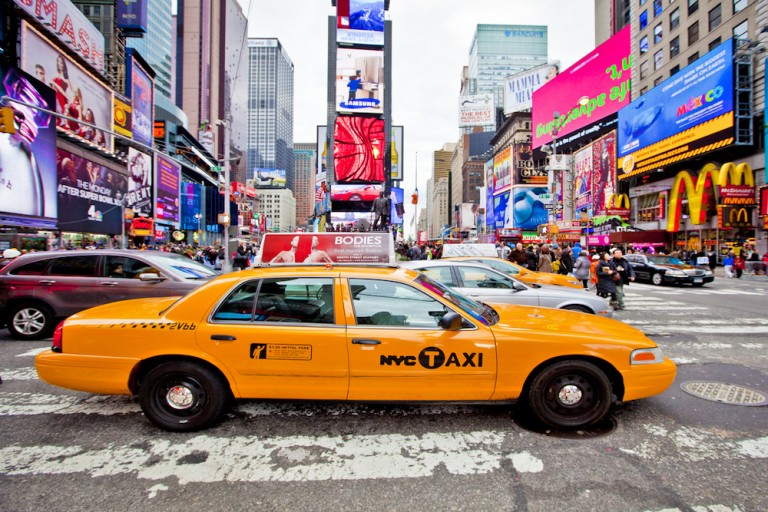

In [3]:
image_url = "https://content.pymnts.com/wp-content/uploads/2016/03/Curb_NYC_Verifone-768x512.jpg"
Image.open(fp=urlopen(f'{image_url}'))